# About:
- this notebook:
    - try to find out how Bayesian target encoding and TargetEncoder affects performance as we increase their regularization parameters
- insights:
    - **target encoding does not yield satifactory gains**
    - it could be that proper steps need to be taken to that encodings do not overfit.
    - future studies can investigate how to make TargetEncoder, WOEEncoding etc. work

### import data

In [1]:
dataset = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\cleaned_train_set.csv",index_col = "respondent_id") 
train_features = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\training_set_features.csv",index_col = "respondent_id")
cat_features = list(train_features.select_dtypes("object").columns )
X = dataset[cat_features]
y = dataset.h1n1_vaccine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
X.head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,1,1,1,1,1,1
2,2,2,0,1,1,0,0,1,2,1,2,2
3,3,1,0,0,0,0,1,0,3,2,0,0
4,4,3,0,0,1,1,0,1,2,1,3,3


### create hold out set 
- without stratify 

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.5,stratify = None)

# Bayesian Target Encoding
- expresses the population mean to some degree in the target encoding - controlled by parameter "m"

In [5]:
def bayesian_target_encode(X_train, y_train, X_test, cols = [], m = 0):
    dataset = pd.concat([X_train,y_train],axis=1)                                        # merge X and y - used for aggregation processes
    target_name = dataset.columns[-1]                                                    # we need target name
    population_mean = y_train.mean()                                                     # population mean of target 
    for col in cols:
        agg = dataset.groupby(col)[target_name].agg(['count', 'mean'])
        counts, means = agg['count'],agg['mean']
        encodings = (counts * means + m * population_mean) / (counts + m)                # compute encodings for the particular feature
        X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test
    return X_train,X_test

In [36]:
encoded_X_train, encoded_X_test = bayesian_target_encode(X_train, y_train, X_test, cols = X_train.columns, m = 300)

<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


In [37]:
encoded_X_train.head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
20065,0.196906,0.236833,0.218457,0.218050,0.198408,0.228771,0.219017,0.213202,0.225525,0.217297,0.205893,0.207027
10984,0.222235,0.236833,0.218457,0.203294,0.253302,0.228771,0.219017,0.216447,0.173946,0.217297,0.205893,0.207027
26159,0.196906,0.236833,0.218457,0.203294,0.253302,0.191110,0.219017,0.213202,0.201909,0.208377,0.227584,0.206350
23929,0.197471,0.209314,0.202486,0.203294,0.253302,0.228771,0.219017,0.213202,0.189488,0.207860,0.172687,0.201001
24104,0.197514,0.185108,0.218457,0.203294,0.198408,0.228771,0.219017,0.216447,0.189488,0.217297,0.205893,0.207027


### evaluate on label encoding - benchmark

In [40]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier,GradientBoostingClassifier, AdaBoostClassifier
param = {"n_estimators":100, 
         "random_state":0}
ensemble_models = {
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()}
ensemble_models  = {k:(v.set_params(**param) if k!="HistGradientBoostingClassifier" else v) for k,v in ensemble_models.items() }

In [50]:
from collections import defaultdict
score_board = defaultdict(list)

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
for model_name, model in ensemble_models.items():
#     score = cross_val_score(model,X_train,y_train,scoring = "roc_auc",cv=3).mean()
#     score_board[model_name].append(score)
    model.fit(X_train,y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    score_board[model_name].append(roc_auc_score(y_test,y_pred))

In [52]:
index = ["label encode"]
pd.DataFrame(score_board,index = index)

<IPython.core.display.Javascript object>

,HistGradientBoostingClassifier,AdaBoostClassifier,GradientBoostingClassifier
label encode,0.62534,0.627034,0.630071


### evaluate bayesian target encoding over varied m

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
for m in [0,50,100,200,300,400,500,1000,2000,3000]:
    encoded_X_train, encoded_X_test = bayesian_target_encode(X_train, y_train, X_test, cols = X_train.columns, m = m)
    index.append(m)
    for model_name, model in ensemble_models.items():
#         score = cross_val_score(model,encoded_X_train,y_train,scoring = "roc_auc",cv=3).mean()
#         score_board[model_name].append(score)
        model.fit(encoded_X_train,y_train)
        y_pred = model.predict_proba(encoded_X_test)[:,1]
        score_board[model_name].append(roc_auc_score(y_test,y_pred))

<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


<IPython.core.display.Javascript object>

<ipython-input-5-51b1ba003cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col],X_test[col] = X_train[col].map(encodings),X_test[col].map(encodings)   # map to train and test


In [54]:
score_board

defaultdict(list,
            {'HistGradientBoostingClassifier': [0.6253399910376456,
              0.6252975083671117,
              0.6213335020816175,
              0.6244090198724195,
              0.6273418802197507,
              0.6237631795416042,
              0.6253890326710978,
              0.6233694577139812,
              0.6252965379083125,
              0.6229270790900161,
              0.622854545660806],
             'AdaBoostClassifier': [0.6270344790291048,
              0.6251736410138375,
              0.6257657882017843,
              0.6260166852654537,
              0.6265098791199867,
              0.6270344790291048,
              0.6265372527509412,
              0.6268072578137243,
              0.627361791357181,
              0.626605971273148,
              0.6263623861145684],
             'GradientBoostingClassifier': [0.6300705928462529,
              0.6271229748323557,
              0.629086564355992,
              0.6300138712026491,
              

### evaluate TargetEncoder 

In [33]:
from category_encoders.target_encoder import TargetEncoder
en = TargetEncoder(cols = cat_features, 
                   smoothing = 0)    # this smoothing might be a different form of smoothing
en.fit(X_train,y_train)
encoded_X_train = en.transform(X_train)
encoded_X_test = en.transform(X_test)

C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
for smoothing in [0,1,2,3,10,20,30,100,200,300]:
    en = TargetEncoder(cols = cat_features, 
                   smoothing = smoothing)    # this smoothing might be a different form of smoothing
    en.fit(X_train,y_train)
    encoded_X_train = en.transform(X_train)
    encoded_X_test = en.transform(X_test)
    index.append(smoothing)
    for model_name, model in ensemble_models.items():
    #     score = cross_val_score(model,encoded_X_train,y_train,scoring = "roc_auc",cv=3).mean()
    #     score_board[model_name].append(score)
        model.fit(encoded_X_train,y_train)
        y_pred = model.predict_proba(encoded_X_test)[:,1]
        score_board[model_name].append(roc_auc_score(y_test,y_pred))

C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\tanch\anaconda3\lib\site-packages\category_encoders

# Results
- we see that **target encoding does not yield much gains at all, compared to label encoding**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'regularization m')]

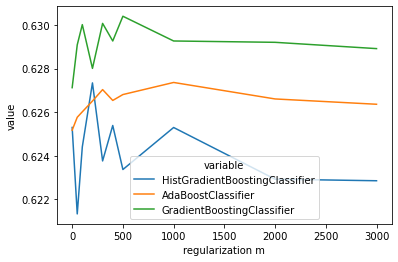

In [65]:
temp_df = pd.melt(score_df.iloc[1:11],id_vars = "index",value_vars = ["HistGradientBoostingClassifier","AdaBoostClassifier","GradientBoostingClassifier"])
sns.lineplot(data = temp_df, x = "index",y = "value", hue = "variable").set(xlabel = "regularization m")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'smoothing')]

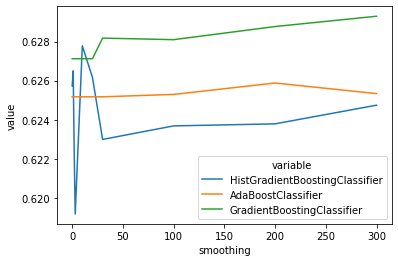

In [64]:
temp_df = pd.melt(score_df.iloc[11:],id_vars = "index",value_vars = ["HistGradientBoostingClassifier","AdaBoostClassifier","GradientBoostingClassifier"])
sns.lineplot(data = temp_df, x = "index",y = "value", hue = "variable").set(xlabel = "smoothing")

In [58]:
score_df = pd.DataFrame(score_board,index = index).reset_index()
score_df

<IPython.core.display.Javascript object>

,index,HistGradientBoostingClassifier,AdaBoostClassifier,GradientBoostingClassifier
0,label encode,0.625340,0.627034,0.630071
1,0,0.625298,0.625174,0.627123
2,50,0.621334,0.625766,0.629087
3,100,0.624409,0.626017,0.630014
4,200,0.627342,0.626510,0.628007
5,300,0.623763,0.627034,0.630071
6,400,0.625389,0.626537,0.629265
7,500,0.623369,0.626807,0.630399
8,1000,0.625297,0.627362,0.629264
9,2000,0.622927,0.626606,0.629203


### Original function 
- I adapted the following function 
    - to work on multiple columns 
    - and test set (shown in previous cells)

In [4]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()
    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])    
    counts = agg['count']
    means = agg['mean']
    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
    # Replace each value by the according smoothed mean
    return df[by].map(smooth)